Digite o nó que enviará a sonda em G: 
Matriz de Sondas Isis =  [[1, 5, 3], [2, 6, 4], [7]] 

    Topology         Where MPolka CRC8 MPolka CRC16 MPINT INT Clássico
0       Isis     DataPlane         606          648   618            0
1       Isis  ControlPlane         495          516   521            0
2    Abilene     DataPlane        1538         1608  1594            0
3    Abilene  ControlPlane         687          708   733            0
4      GEANT     DataPlane        3699         3972  4041            0
5      GEANT  ControlPlane        3033         3180  3323            0
6    GridNet     DataPlane         808          864   856            0
7    GridNet  ControlPlane         644          672   684            0
8   FORTHNET     DataPlane        3809         4236  4247            0
9   FORTHNET  ControlPlane        5679         6036  6253            0
10    GetNet     DataPlane         462          504   458            0
11    GetNet  ControlPlane         548          576   

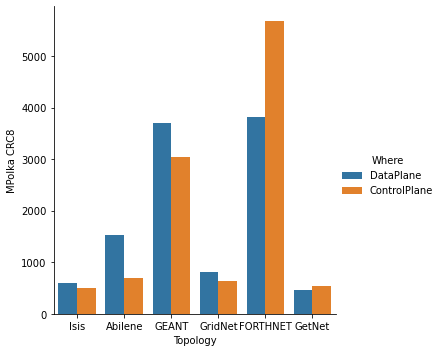

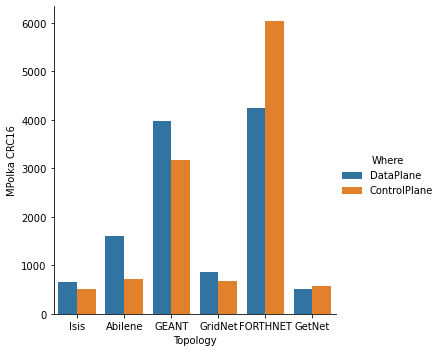

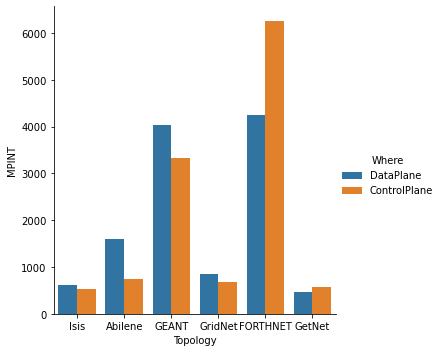

In [68]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import glob

GIsis = nx.from_edgelist([[1,5],[5,3],[1,2],[2,6],[6,4],[6,7]])
#GIsis = nx.from_edgelist([[0, 1], [0, 2], [1, 10], [2, 9], [10, 7], [9, 8], [3, 6], [4, 6], [6, 7], [5, 8]])
sonda = []
sondaTemp = []

overhead_DataPlane_MPINT = []
overhead_ControlPlane_MPINT = []
overhead_DataPlane_MPolkaCRC8 = []
overhead_ControlPlane_MPolkaCRC8 = []
overhead_DataPlane_MPolkaCRC16 = []
overhead_ControlPlane_MPolkaCRC16 = []
overhead_DataPlane_INTClassico = []
overhead_ControlPlane_INTClassico = []
overhead_MPINT_Temp = []
overhead_MPolkaCRC8_Temp = []
overhead_MPolkaCRC16_Temp = []
overhead_INTClassico_Temp = []


def EdgeListToMST(path):
    edgeList = readTopology(path)
    #print(edgeList)
    G = nx.from_edgelist(edgeList)
    T = nx.minimum_spanning_tree(G,algorithm='prim')
    #print(T)
    return T

def GMLToMST(path):
    G = nx.read_gml(path,destringizer=int,label='id') #
    topologyName = G.graph['Network'] #Hooka o atributo network que identifica o nome da Topologia
    edgeList = list(map(list,G.edges()))
    #print(edgeList)
    G = nx.from_edgelist(edgeList)
    T = nx.minimum_spanning_tree(G,algorithm='prim')
    edgeList = list(map(list, T.edges()))
    T = nx.from_edgelist(edgeList)
    #print(T)
    return T,topologyName


def toDataframe(df,topology,sonda):
    #Overhead por abordagem
    overheadDP_mPolkaCRC8 = sum(sum(overhead_DataPlane_MPolkaCRC8,[]))
    overheadDP_mPolkaCRC16 = sum(sum(overhead_DataPlane_MPolkaCRC16,[]))
    overheadDP_mPINT = sum(sum(overhead_DataPlane_MPINT,[]))
    overheadDP_INTClassico = sum(sum(overhead_DataPlane_INTClassico,[]))

    overheadCP_mPolkaCRC8 = sum(overhead_ControlPlane_MPolkaCRC8)
    overheadCP_mPolkaCRC16 = sum(overhead_ControlPlane_MPolkaCRC16)
    overheadCP_mPINT = sum(overhead_ControlPlane_MPINT)
    overheadCP_INTClassico = sum(overhead_ControlPlane_INTClassico)

    matrixOverhead = {}
    matrixOverhead['Topology'] = [topology,topology]
    matrixOverhead['Where'] = ['DataPlane','ControlPlane']
    matrixOverhead['MPINT'] = [overheadDP_mPINT,overheadCP_mPINT]
    matrixOverhead['MPolka CRC8'] = [overheadDP_mPolkaCRC8,overheadCP_mPolkaCRC8]
    matrixOverhead['MPolka CRC16'] = [overheadDP_mPolkaCRC16,overheadCP_mPolkaCRC16]
    matrixOverhead['INT Clássico'] = [overheadDP_INTClassico,overheadCP_INTClassico]
    df2 = pd.DataFrame(data=matrixOverhead)
    result = pd.concat([df,df2],ignore_index=True)
    return result

def appendGraphToDataFrame(df,path):
    G,topologyName = GMLToMST(path)
    sondaAux = dfs_init(G,node)
    #print(topologyName,'Edges = ', G.edges())
    #print('Matriz de Sondas',topologyName,' =',sondaAux,'\n')
    df = toDataframe(df,topologyName,sondaAux)
    return df

def appendAllTopologysToDataFrame(df):
    listTopology = glob.glob('topologyZoo/*.gml')
    for topology in listTopology:
        df = appendGraphToDataFrame(df,topology)
    return df

def readTopology(path):
    edgeList = []

    with open(path,'r') as arq:
        lines = arq.readlines()
    
    for i in range(len(lines)):
        line = lines[i].split(' ')
        line.pop()
        line = list(map(int,line))
        edgeList.append(line)
        #print(line)
    
    return edgeList

def calculaOverheads(sonda,hops):
    #CABEÇALHO DO MPINT
    mPINT_Ethernet = 14
    mPINT_Ip = 20
    mPINT_INTHeader = 12
    mPINT_StackINT = 48
    mPINT_PathHeader = 1
    mPINT_StackPath = 4
    fixo_MPINT = mPINT_Ethernet + mPINT_Ip + mPINT_INTHeader + mPINT_PathHeader


    tamanhoSonda = len(sonda)
    if(hops == 0):
        return 0#SEM SALTOS, SEM OVERHEAD
    
    #PARA O MPINT
    overhead_MPINT_Temp.append(calculaOverheadMPINT(tamanhoSonda,hops))

    #PARA O MPOLKA CRC8
    overheadCRC8, overheadCRC16 = calculaOverheadMPolka(tamanhoSonda)
    overhead_MPolkaCRC8_Temp.append(overheadCRC8)
    overhead_MPolkaCRC16_Temp.append(overheadCRC16)
    #PARA O MPOLKA CRC16

def calculaOverheadMPINT(tamanhoSonda,hops):
    #CABEÇALHO DO MPINT
    mPINT_Ethernet = 14
    mPINT_Ip = 20
    mPINT_INTHeader = 12
    mPINT_StackINT = 48
    mPINT_PathHeader = 1
    mPINT_StackPath = 4
    fixo_MPINT = mPINT_Ethernet + mPINT_Ip + mPINT_INTHeader + mPINT_PathHeader

    if(hops == 0):
        return 0 #SEM SALTOS, SEM OVERHEAD

    #Overhead para o MPINT
    routeOverheadMPINT = mPINT_StackPath * hops
    telemetryOverheadMPINT = mPINT_StackINT * (tamanhoSonda-1)
    overhead = fixo_MPINT + routeOverheadMPINT + telemetryOverheadMPINT
    return overhead

def calculaOverheadMPolka(tamanhoSonda):
    #CABEÇALHO DO MPOLKA
    mPolka_Ethernet = 14
    mPolka_Ip = 20
    mPolka_INTHeader = 12
    mPolka_StackINT = 48
    mPolka_routeID_CRC8 = 7
    mPolka_routeID_CRC16 = 14
    fixo_MPolkaCRC8 = mPolka_Ethernet + mPolka_routeID_CRC8 + mPolka_Ip + mPolka_INTHeader
    fixo_MPolkaCRC16 = mPolka_Ethernet + mPolka_routeID_CRC16 + mPolka_Ip + mPolka_INTHeader

    #Overhead para o MPolka
    telemetryOverheadMPolka = mPolka_StackINT * (tamanhoSonda-1)
    overheadCRC8 = fixo_MPolkaCRC8 + telemetryOverheadMPolka
    overheadCRC16 = fixo_MPolkaCRC16 + telemetryOverheadMPolka

    return overheadCRC8,overheadCRC16

def deadEndRelease(sonda,hops):
    #RELEASE OVERHEAD MPINT
    overhead_DataPlane_MPINT.append(overhead_MPINT_Temp.copy())
    overhead_ControlPlane_MPINT.append(calculaOverheadMPINT(len(sondaTemp)+1,hops))
    overhead_MPINT_Temp.clear()

    #RELEASE OVERHEAD MPOLKA
    overhead_DataPlane_MPolkaCRC8.append(overhead_MPolkaCRC8_Temp.copy())
    overhead_DataPlane_MPolkaCRC16.append(overhead_MPolkaCRC16_Temp.copy())
    overheadCRC8, overheadCRC16 = calculaOverheadMPolka(len(sondaTemp)+1)
    overhead_ControlPlane_MPolkaCRC8.append(overheadCRC8)
    overhead_ControlPlane_MPolkaCRC16.append(overheadCRC16)
    overhead_MPolkaCRC8_Temp.clear()
    overhead_MPolkaCRC16_Temp.clear()

    #RELEASE OVERHEAD INT CLASSICO

    #RELEASE PROBE
    sonda.append(sondaTemp.copy())
    sondaTemp.clear()

def dfs(G,v,visited,hops,previousHop): #Retorna a matriz de sondas do MPolka
    visited[v] = True
    sondaTemp.append(v)
    grau = G.degree(v)
    calculaOverheads(sondaTemp,hops)
    hops += 1
    for w in G.neighbors(v):
        if grau == 1: #DEADEND
            deadEndRelease(sonda,hops)
        if not visited[w]:
            if grau == 2: #TRANSMISSÃO
                dfs(G,w,visited,hops,previousHop)
            else: #BIFURCAÇÃO
                previousHop = hops
                dfs(G,w,visited,hops,previousHop)
    return sonda

def dfs_init(G,v):
    visited=[False] * (G.number_of_nodes() + 1)
    sonda.clear()
    overhead_DataPlane_MPINT.clear()
    overhead_ControlPlane_MPINT.clear()
    overhead_DataPlane_MPolkaCRC8.clear()
    overhead_ControlPlane_MPolkaCRC8.clear()
    overhead_DataPlane_MPolkaCRC16.clear()
    overhead_ControlPlane_MPolkaCRC16.clear()
    overhead_ControlPlane_INTClassico.clear()
    overhead_DataPlane_INTClassico.clear()
    sondaAux = dfs(G,v,visited,hops=0,previousHop=0)
    return sondaAux

print('Digite o nó que enviará a sonda em G: ')
node = int(input())

df = pd.DataFrame(columns=['Topology','Where','MPolka CRC8','MPolka CRC16','MPINT','INT Clássico']) #Empty Row Dataframe

sondaIsis = dfs_init(GIsis,node)
print('Matriz de Sondas Isis = ',sondaIsis,'\n')
df = toDataframe(df,'Isis',sondaIsis) #DataFrame Isis Example


#print('DP MPINT:',overhead_DataPlane_MPINT)
#print('CP MPINT:',overhead_ControlPlane_MPINT)
#
#print('DP MPolka CRC8:',overhead_DataPlane_MPolkaCRC8)
#print('CP MPolka CRC8:',overhead_ControlPlane_MPolkaCRC8)
#print('DP MPolka CRC16:',overhead_DataPlane_MPolkaCRC16)
#print('CP MPolka CRC16:',overhead_ControlPlane_MPolkaCRC16)


df = appendAllTopologysToDataFrame(df)
print(df)
df.to_csv('overhead.csv',index=False)

#sns.displot(df, x="MPolka",hue="Where",element="step");
sns.catplot(x="Topology", y="MPolka CRC8", hue="Where",kind="bar", data=df, errorbar = None);
sns.catplot(x="Topology", y="MPolka CRC16", hue="Where",kind="bar", data=df, errorbar = None);
sns.catplot(x="Topology", y="MPINT", hue="Where",kind="bar", data=df, errorbar = None);
#sns.catplot(x="Topology", y="INT Clássico", hue="Where",kind="bar", data=df, errorbar = None);
